 # Prediction of FRONTEX illegal border crossings using GTI in a LSTM model
 
 ## Contents:
* 1. [Preparation](#1)
   * 1.1. [GTI and IBC data](#1.1)
       * 1.2.1. [Google Trends Index data](#1.1.1)
       * 1.2.2. [Illegal Border Crossings data](#1.1.2)
   * 1.2. [Merged data](#1.2)
* 2. [LSTM model](#2)
   * 2.1. [Model Geometry](#2.1)
   * 2.2. [Loss functions](#2.2)
   * 2.3. [Model evaluation](#2.3)
   * 2.4. [Model Visualization](#2.4)
* 3. [Results](#3)
   * 3.1. [Baseline model](#3.1)
       * 3.1.1. [Without Google Trend Indices](#3.1.1)
       * 3.1.2. [With Google Trend Indices](#3.1.2)
   * 3.2. [Results with GTI](#3.2)
   * 3.3. [Hyperparameter search](#3.3)

In [1]:
import keras.backend as kb
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
from tensorflow import keras
from keras.regularizers import L1L2
from keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.colors import SymLogNorm
import sys 

location_data='C:\\Users\\adema\\Documents\\ifo\\ifo\\Coursework\\ML\\Term Paper Project\\'

 # 1. Preparation <a id="1">

 ## 1.1 GTI and IBC data <a id="1.1">
    
    In this section, we import the data that have been queried in run_gtitan_create.ipynb and we briefly plot it. For more details about the sourcing, see there and the report. 
    First, we consider one of the Trends series over time, namely that of the keyword "migration" in Syria from 2004 to 2021. Note that the GTI index is noisier in earlier time periods, likely because of lower sampling rates of search traffic and a lower total volume of the internet traffic. We observe multiple peaks in the summer months of 2013,2014,2015, indicating a higher relative interest in "migration", compared to other search patterns. This interest flattens after 2016.
    
    Second, we will consider the Frontex data in terms of the monthly illegal border crossings towards Europe between January 2009 and November 2020, summing over all countries of origin and routes. We clearly observe the strong peak around the midst of the migrant crisis in 2015.

  ### 1.1.1 Google Trends Index data <a id="1.1.1">

Text(0, 0.5, 'GT Index [Normalized]')

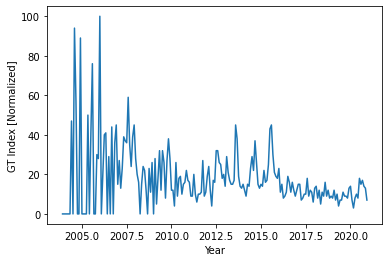

In [2]:
gti_df = pd.read_csv(location_data+'Data\\timeframe.csv')
a = gti_df[gti_df['geo']=='SY']['migration']
plt.plot(a.index/12+791,a.values)
plt.xlabel('Year')
plt.ylabel('GT Index [Normalized]')

   ### 1.1.2 Illegal Border Crossings data <a id="1.1.2">

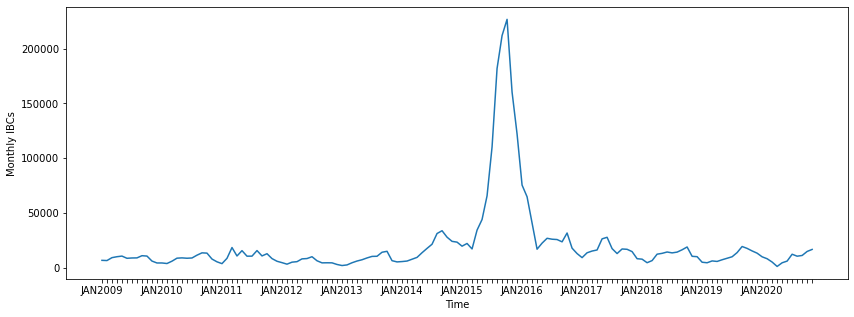

In [3]:
flow_df = pd.read_csv(location_data+'Data\\raw_migration_flows.csv')
y = flow_df.sum()[1:]
x = flow_df.columns[1:]
import sys
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(14,5))
plt.plot(x,y)
every_nth = 12
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
plt.xlabel('Time')
plt.ylabel('Monthly IBCs')
plt.savefig('Flow_data.png')

 ## 1.2 Merged data <a id="1.2">
    
    Here we source the data, apply the minmax scaler to the data where necessary and make into list
    We put out two different dataframes:  lstm_df_base without GTI and lstm_df_gti with GTI

In [4]:
lstm_df = pd.read_pickle(location_data+'Data\\lstm_df.pkl')

def extractList(lst): 
    return list(map(lambda el:[el], lst))                                                
def listMaker(row):
    return extractList(row['mig_flow'])
lstm_df['mig_flow'] = lstm_df.apply(listMaker, axis=1)

#Scale the data on a min-max basis: (OVER ALL features!) TOCHECK
lstm_df['GTI'] = lstm_df['GTI'].apply(np.array).T.apply(MinMaxScaler(feature_range=(0, 1)).fit_transform).apply(np.ndarray.tolist)
lstm_df['Country FE'] = lstm_df['Country FE'].apply(np.array).T.apply(MinMaxScaler(feature_range=(0, 1)).fit_transform).apply(np.ndarray.tolist)
lstm_df['mig_flow_norm'] = lstm_df['mig_flow'].apply(MinMaxScaler(feature_range=(0, 1)).fit_transform).apply(list)
lstm_df['GTI'] = lstm_df['GTI'].tolist()
lstm_df['Country FE'] = lstm_df['Country FE'].tolist()

#Function to parse rows in list for later use
def makeTRows(row):
    row['X']=list(map(list, zip(*row['X'])))

#Add all desired covariates in a column X
lstm_df_base = lstm_df
lstm_df_base['X'] = lstm_df_base['Country FE']+lstm_df_base['Route FE']+lstm_df_base['Time FE']#+lstm_df['GTI']
x_transpose=pd.DataFrame()
x_transpose['X']=lstm_df_base['X']
x_transpose.apply(makeTRows,axis=1)
lstm_df_base['X']=x_transpose['X']

#Add all desired covariates in a column X, including the GTI
lstm_df_gti = lstm_df
lstm_df_gti['X'] = lstm_df_gti['Country FE']+lstm_df_gti['Route FE']+lstm_df_gti['Time FE']+lstm_df_gti['GTI']
x_transpose=pd.DataFrame()
x_transpose['X']=lstm_df_gti['X']
x_transpose.apply(makeTRows,axis=1)
lstm_df_gti['X']=x_transpose['X']

#Show first entry of the combined data set
lstm_df_gti.reset_index().head(1)


,index,Route,Nationality,ISO2,Country_route_ID,mig_flow,time,index_l,arrival_l,emigrant_l,...,waiver_l,GTI,Country FE,Route FE,Country-Route FE,Time FE,mig_flow_L12,mig_flow_L1,mig_flow_norm,X
0,0,Black Sea Route,Afghanistan,AF,0,"[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","[2009-01-01T00:00:00.000000000, 2009-02-01T00:...","[60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 7...","[0, 0, 0, 0, 38, 0, 37, 0, 0, 36, 73, 0, 0, 39...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[83, 0, 0, 0, 0, 0, 58, 0, 0, 0, 0, 0, 54, 63,...","[[0.7228915662650602, 1.0, 1.0, 0.63, 0.888888...","[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0....","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


 # 2. LSTM <a id="2">

 ## 2.1 Loss functions <a id="2.1">

    We define two models, one with and one without L1 weight regularization

In [5]:
# Common Part of Commuters 
def cpc(y_true, y_pred):
    return (2.0 * kb.sum(kb.minimum(y_true, y_pred))) / (kb.sum(y_true) + kb.sum(y_pred))
# Common Part of Commuters loss function
def cpc_loss(y_true, y_pred):
    return 1.0 - cpc(y_true, y_pred)

loss = [cpc_loss, 'mse'] # to be passed to model.compile(), loss parameter
custom_metrics = [cpc, 'mse'] # to be passed to model.compile(), metrics parameter

## 2.2 Model Geometry <a id="2.2">

In [6]:
def lstmModel(data, loss = cpc_loss, size_hidden_layer = 50, dropout = 0.0):
    '''
    data              : a dataframe like the transformData return
    l                 : loss function to build model
    size_hidden_layer : size of the LSTM's hidden layer
    dropout           : value of the model's dropout
    returns           : the defined model
    '''
    n_features = len(data['X'][0][0]) 
    model = Sequential()
    if dropout > 0.0:
        model.add(Dropout(dropout, input_shape=(1, n_features)))
    model.add(LSTM(size_hidden_layer, activation='relu', input_shape=(1, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss=loss, metrics = custom_metrics)
    return model
def lstmModelReg(data, loss = cpc_loss, size_hidden_layer = 50, dropout = 0.0):
    '''
    data              : a dataframe like the transformData return
    l                 : loss function to build model
    size_hidden_layer : size of the LSTM's hidden layer
    dropout           : value of the model's dropout
    returns           : the defined model
    '''
    n_features = len(data['X'][0][0]) 
    model = Sequential()
    if dropout > 0.0:
        model.add(Dropout(dropout, input_shape=(1, n_features)))
    model.add(LSTM(size_hidden_layer, recurrent_regularizer=L1L2(l1=0.001, l2=0.0), activation='relu', input_shape=(1, n_features)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(lr=0.0005), loss=loss, metrics = custom_metrics)
    return model

## 2.3 Model evaluation <a id="2.3">

In [7]:
def train_evaluate(model, data, verbose = 1, epoch = 1, test_month = np.datetime64('2020-11-01'), normBySerie = True, use_log = False, normInTotal = False, evaluate_freq = 1):
    '''
    model         : lstm (keras model)
    data          : a dataframe like the transformData return
    verbose       : should I show epoch (0 shut up) 
    epoch         : number of epoch
    test_year     : the year used as test set
    normBySerie   : indicates for the evaluation if @data was normed by serie origin-destination
    use_log       : indicates for the evaluation if the log values was used in @data
    normInTotal   : indicates for the evaluation if @data was normed for all series origin-destination
    evaluate_freq : the model is evaluated every @evaluate_freq epochs
    returns       : the history of the different metrics for every evaluation done
    '''
    def trainModel(row):
        X, y = row['X'], row['mig_flow_norm'] # I take a series that is a pair origin-destination spanning from 2004-2014 (some missing years maybe)
        if test_month in row['time']: # Remove the test year from the train
            X, y = row['X'][:-1], row['mig_flow_norm'][:-1]
        if len(X) != 0:
            y=np.array(y)
            X = np.array(X).reshape((len(X),1,len(X[0]))) # batch size, years I take, # of feats
            model.fit(X, y, epochs = 1, verbose = 0, shuffle = False) # loss, metrics for the train

    history = [] # for train and test metrics at every epoch
    for j in range(epoch): # repeat the traning on the whole data epoch times
        data.apply(trainModel,axis=1)
        if j%evaluate_freq == 0: #evaluation on all the different metrics
            dataResult = evaluateBySerie(model, data, normBySerie = normBySerie, use_log = use_log, normInTotal = normInTotal)
            train_metrics, test_metrics, total_train_metrics, total_test_metrics = totalEvaluation(dataResult, display = False, test_month = test_month)
            history.append(total_train_metrics + total_test_metrics )
            print('EPOCH :', j + 1)
            if verbose > 0:
                print('train rmse : ' + str(total_train_metrics[0]) + ' - train cpc : ' + str(total_train_metrics[1]))
                print('test rmse : ' + str(total_test_metrics[0]) + ' - test cpc : ' + str(total_test_metrics[1]))
    return list(map(list,zip(*history)))


In [8]:
# Calculate CPC as a numpy array
def CPC(y,y_pred):
    return 2 * np.sum(np.minimum(y,y_pred))/(np.sum(y)+np.sum(y_pred))

def calculate_metrics(y,y_pred):
    rmse = np.sqrt(metrics.mean_squared_error(y,y_pred))
    Cpc = CPC(y,y_pred)
    return [rmse,Cpc]

def evaluateBySerie(model, newData, normBySerie = True, use_log = False, normInTotal = False):
    tot_mig = np.array([el for serie in list(newData['mig_flow']) for el in serie])
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(tot_mig)
    def evaluateRow(row):
        X, y, y_real = row['X'], row['mig_flow_norm'], row['mig_flow']
        X = np.array(X).reshape((len(X), 1, len(X[0])))
        y_pred = model.predict(X,verbose=0)
        y_real_pred = y_pred
        if normBySerie:
            scalerSerie = MinMaxScaler(feature_range=(0, 1)).fit(y_real)
            y_real_pred = scalerSerie.inverse_transform(y_pred)
        elif use_log:
            y_real_pred = np.exp(y_pred)-1
        elif normInTotal:
            y_real_pred = scaler.inverse_transform(y_pred)
        y=np.array(y)
        y_real=np.array(y_real)
        y = y.flatten()
        y_pred = y_pred.flatten()
        y_real_pred = y_real_pred.flatten()
        y_diff = np.subtract(y_real_pred.flatten(), y_real.flatten())
        res = [y_pred,y_real_pred,y_diff] + calculate_metrics(y,y_pred) + calculate_metrics(y_real,y_real_pred)
        return res
    res = np.array(newData.apply(evaluateRow,axis=1).to_list())
    newDF =  pd.DataFrame(res, columns=['y_pred', 'y_real_pred', 'y_diff', 'rmse', 'cpc', 'rmse_total', 'cpc_total'], index=newData.index)
    return pd.concat([newData,newDF], axis=1)

# Evaluate the LSTM model by calculating for the complete data the metrics rmse and cpc
# Here, train_metrics and test_metrics refer to the minmaxscaler-normalized set, 
# whereas total_train_metrics and total_test_metrics       : the normalized test set

def totalEvaluation(data,test_month = np.datetime64('2020-11-01'),display=True):
    def separate(row):
        if test_month in row['time']:
            return [row['mig_flow_norm'][:-1],[row['mig_flow_norm'][-1]],row['y_pred'][:-1],[row['y_pred'][-1]],row['mig_flow'][:-1],[row['mig_flow'][-1]],row['y_real_pred'][:-1],[row['y_real_pred'][-1]]]
        else:
            return [row['mig_flow_norm'],[],row['y_pred'],[],row['mig_flow'],[],row['y_real_pred'],[]]
    def flatten(l):
        return [[x for serie in set for x in serie] for set in l]
    allData = data.apply(separate,axis=1)
    allData = list(map(list,zip(*allData)))
    [y_train,y_test,y_train_pred,y_test_pred,y_real_train,y_real_test,y_real_train_pred,y_real_test_pred] = flatten(allData)
    if display:
        y_real = np.array(y_real_train + y_real_test)
        y_pred = np.array(y_real_train_pred + y_real_test_pred)
        scatter_plot(np.array(y_real_test),np.array(y_real_test_pred),'scatter_LSTM.svg')
    y_real_train = np.array(y_real_train).reshape((len(y_real_train)))
    y_train = np.array(y_train).reshape((len(y_train)))
    y_real_test = np.array(y_real_test).reshape((len(y_real_test)))
    y_test = np.array(y_test).reshape((len(y_test)))
    train_metrics = calculate_metrics(y_train, y_train_pred)
    test_metrics = calculate_metrics(y_test, y_test_pred)
    total_train_metrics = calculate_metrics(y_real_train, y_real_train_pred)
    total_test_metrics = calculate_metrics(y_real_test, y_real_test_pred)
    return train_metrics, test_metrics, total_train_metrics, total_test_metrics

## 2.4 Model Visualization <a id="2.4">

In [9]:
# Display the training history of the model, the values of the different metrics
# as returned by train_evaluate
#
# @history : of the different metrics by epoch for a given model
def display_training(history, name='default'):
    model_metrics = history
    half = int(len(model_metrics) / 2)
    name_metrics = ['rmse', 'cpc']
    #First half is training, second half is testing:
    train_metrics, val_metrics = model_metrics[:half], model_metrics[half:]
    ratio = 10 # for figure size
    fig, ax = plt.subplots(half, figsize = (1 * ratio, 2 * ratio))
    fig.tight_layout(pad=3.0)
    for i in range(half):
        ax[i].set_title(name_metrics[i] + ' on train and test sets')
        ax[i].plot(train_metrics[i])
        ax[i].plot(val_metrics[i])
        ax[i].set_ylabel(name_metrics[i])
        ax[i].set_xlabel('Number of epochs')
        ax[i].legend(['Train', 'Test'], loc='upper right')
        plt.savefig(name+'.png')

In [10]:
# Draw a scatter plot from the predicted and observed values
def scatter_plot(y_real,y_pred,name=None):
    fig = plt.figure(figsize=(10,10))
    plt.scatter(y_real,y_pred,c='r',alpha=0.5)
    plt.plot(range(0, int(np.max(y_real))),range(0, int(np.max(y_real) )),'g')
    plt.xlabel('Observed values')
    plt.ylabel('Predicted values')
    plt.yscale('log')
    plt.xscale('log') 
    plt.show()
    if name is not None:
        fig.savefig(name)


 # 3. Results <a id="3">
## 3.1 Baseline model  <a id="3.1">
    
    We train the model on data of january 2019 until October 2020. We test the trained model on data of a single month: 
    November 2020
    
### 3.1.1 Without Google Trend Indices <a id="3.1.1">

In [ ]:
data = lstm_df_base
model = lstmModel(data,loss=cpc_loss,size_hidden_layer=70,dropout=0.2)
history_base_now = train_evaluate(model, data, test_month = np.datetime64('2020-11-01'), verbose = 1, epoch = 70)
display_training(history_base_now,name='base_no_weights')
dataResult = evaluateBySerie(model,lstm_df_base)
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)

<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 1
train rmse : 910.45240793138 - train cpc : 0.31557253503818106
test rmse : 762.7170682946669 - test cpc : 0.27714655256867


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 2
train rmse : 865.5602260256718 - train cpc : 0.34003989702017484
test rmse : 641.0440777075069 - test cpc : 0.29670272394022695


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 3
train rmse : 831.2186938460868 - train cpc : 0.355471760240468
test rmse : 584.9278249872531 - test cpc : 0.31341687184143213


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 4
train rmse : 813.0218097782024 - train cpc : 0.3660830047497357
test rmse : 605.4052591576343 - test cpc : 0.3070465733052918


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 5
train rmse : 804.7975283803431 - train cpc : 0.37322491991849144
test rmse : 511.041107696824 - test cpc : 0.3294466655881612


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 6
train rmse : 808.6541588365425 - train cpc : 0.37521290249056916
test rmse : 491.1645129656788 - test cpc : 0.3377088526276707


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 7
train rmse : 812.1046830634785 - train cpc : 0.3784990312578087
test rmse : 506.99977282798216 - test cpc : 0.3322630589132471


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 8
train rmse : 815.1804675113605 - train cpc : 0.37899588440240395
test rmse : 565.9806978781763 - test cpc : 0.3182012848490151


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 9
train rmse : 808.6696816529839 - train cpc : 0.38124636126006817
test rmse : 561.4245244917073 - test cpc : 0.315627946302467


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 10
train rmse : 810.6066826151321 - train cpc : 0.3795493783631413
test rmse : 575.486045317911 - test cpc : 0.315493646656964


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 11
train rmse : 806.231092346148 - train cpc : 0.3850445793605572
test rmse : 494.8274010462094 - test cpc : 0.3253101358496849


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 12
train rmse : 811.0182474863617 - train cpc : 0.3883750619103963
test rmse : 532.7108801638385 - test cpc : 0.32622233554457297


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 13
train rmse : 792.2539590192653 - train cpc : 0.3918688692459252
test rmse : 470.27273643848497 - test cpc : 0.3429010278263782


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 14
train rmse : 811.3105362190737 - train cpc : 0.38525221685181854
test rmse : 553.0601854898854 - test cpc : 0.31947588035176977


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 15
train rmse : 803.1516774018443 - train cpc : 0.39652051508813124
test rmse : 476.65546521657114 - test cpc : 0.32391165387702503


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 16
train rmse : 874.0576873121654 - train cpc : 0.3735828427095938
test rmse : 651.8508500701366 - test cpc : 0.2998690405154599


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 17
train rmse : 846.850233508022 - train cpc : 0.3866190022310964
test rmse : 558.9415048244379 - test cpc : 0.31472116939189393


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 18
train rmse : 778.568688959778 - train cpc : 0.40488458861346965
test rmse : 418.0617241759613 - test cpc : 0.3288741900490463


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 19
train rmse : 822.5257726576301 - train cpc : 0.3939641584692849
test rmse : 522.0796335581008 - test cpc : 0.3349134877223593


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 20
train rmse : 865.0344299104748 - train cpc : 0.3857971764395999
test rmse : 611.7939286967874 - test cpc : 0.29957282273964997


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 21
train rmse : 815.1476302083639 - train cpc : 0.3995509349385294
test rmse : 542.2797168892321 - test cpc : 0.31924834537714747


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 22
train rmse : 834.6418508034786 - train cpc : 0.3952195983391947
test rmse : 502.4005313475012 - test cpc : 0.32276283765228503


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 23
train rmse : 809.1138481947986 - train cpc : 0.4012306931152103
test rmse : 470.2436343463776 - test cpc : 0.3226552408000828


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 24
train rmse : 828.6670930619404 - train cpc : 0.3970422439845557
test rmse : 470.01944739817066 - test cpc : 0.32071357687106516


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 25
train rmse : 795.9969176165403 - train cpc : 0.4040907061166694
test rmse : 448.64088625079125 - test cpc : 0.3219155696041957


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 26
train rmse : 812.4178791794998 - train cpc : 0.4078801306365042
test rmse : 434.53502625417946 - test cpc : 0.32771968121358525


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 27
train rmse : 826.6582589065515 - train cpc : 0.3925713977559376
test rmse : 491.882037692244 - test cpc : 0.3099720946268554


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 28
train rmse : 809.555216052516 - train cpc : 0.40918457761459587
test rmse : 429.8394922371454 - test cpc : 0.3230871733801654


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 29
train rmse : 838.7528080933977 - train cpc : 0.3992648870571291
test rmse : 476.9746761259953 - test cpc : 0.3150972332081517


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 30
train rmse : 815.0487204746547 - train cpc : 0.40985384682368176
test rmse : 458.6746171454017 - test cpc : 0.33652837379585326


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 31
train rmse : 819.8209165261458 - train cpc : 0.40436816993201746
test rmse : 423.0261449438705 - test cpc : 0.3166889539107672


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 32
train rmse : 819.216739974685 - train cpc : 0.4102363028109484
test rmse : 433.74177612816567 - test cpc : 0.3041004795746194


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 33
train rmse : 801.4123652535844 - train cpc : 0.41384241506245834
test rmse : 419.1215533268065 - test cpc : 0.32216304235928156


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 34
train rmse : 797.4268584196286 - train cpc : 0.418921424990782
test rmse : 425.08120078531726 - test cpc : 0.3327194968670219


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 35
train rmse : 822.8726503284921 - train cpc : 0.4061693393869923
test rmse : 475.4065119328804 - test cpc : 0.3295980845649882


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 36
train rmse : 814.1955151782173 - train cpc : 0.41151237541176855
test rmse : 472.3910015022064 - test cpc : 0.3263497347886344


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 37
train rmse : 826.2949011471662 - train cpc : 0.4112227870900277
test rmse : 446.5476708117403 - test cpc : 0.33269806161916254


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 38
train rmse : 848.5726339597205 - train cpc : 0.4028325057700697
test rmse : 459.63215993345545 - test cpc : 0.32764920549707005


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 39
train rmse : 864.5796746248469 - train cpc : 0.40525159141907563
test rmse : 470.621056398924 - test cpc : 0.3172564464217008


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 40
train rmse : 801.4742985042152 - train cpc : 0.4174995193764004
test rmse : 375.33500413230723 - test cpc : 0.324068724976611


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 41
train rmse : 804.2758551123993 - train cpc : 0.41727196606934774
test rmse : 392.08549889155444 - test cpc : 0.3328126357541447


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 42
train rmse : 796.9234997916539 - train cpc : 0.4245776243451873
test rmse : 369.08666646897007 - test cpc : 0.32599267521947256


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 43
train rmse : 825.40583635875 - train cpc : 0.4173127757287322
test rmse : 341.8162874487631 - test cpc : 0.3291020427018359


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 44
train rmse : 812.1338678575875 - train cpc : 0.42083208932119276
test rmse : 408.877354730528 - test cpc : 0.32293755841423716


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 45
train rmse : 827.6682603597058 - train cpc : 0.4223056613577753
test rmse : 372.93333106994817 - test cpc : 0.3149069583237391


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 46
train rmse : 807.4897642596669 - train cpc : 0.4234476187392571
test rmse : 370.67995783367604 - test cpc : 0.3211412538830241


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 47
train rmse : 840.8152264831236 - train cpc : 0.4207011962202118
test rmse : 402.4022646337388 - test cpc : 0.31098184169822873


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 48
train rmse : 821.9254145297724 - train cpc : 0.4217086702188131
test rmse : 383.2541334832365 - test cpc : 0.31601521730466303


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 49
train rmse : 797.0651582728391 - train cpc : 0.42443995688726877
test rmse : 367.3654070945377 - test cpc : 0.32378586016809446


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 50
train rmse : 779.8513741124349 - train cpc : 0.4288382595011947
test rmse : 345.4004449202214 - test cpc : 0.32393409986737004


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 51
train rmse : 818.5349680131221 - train cpc : 0.42280254470128154
test rmse : 379.87664553240285 - test cpc : 0.3182761055765346


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 52
train rmse : 817.0235987432751 - train cpc : 0.4263908792729101
test rmse : 350.23057917194217 - test cpc : 0.32603355398641276


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 53
train rmse : 792.3121088958957 - train cpc : 0.43128335256861317
test rmse : 346.0093885926512 - test cpc : 0.330824776085344


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 54
train rmse : 819.5259044553779 - train cpc : 0.42670492321197456
test rmse : 384.61033748938655 - test cpc : 0.3114915713452755


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 55
train rmse : 871.3861063018298 - train cpc : 0.41248243309964283
test rmse : 394.0108026639061 - test cpc : 0.31004328884862103


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 56
train rmse : 865.3781125009041 - train cpc : 0.41734942155109356
test rmse : 390.4661876340599 - test cpc : 0.3220815438190743


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 57
train rmse : 814.2698911121565 - train cpc : 0.42780874173866124
test rmse : 365.53756421652497 - test cpc : 0.32450059991021374


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 58
train rmse : 844.8714882196552 - train cpc : 0.428270818469254
test rmse : 412.43723139413163 - test cpc : 0.3059777264408803


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 59
train rmse : 860.1701689343897 - train cpc : 0.4211424785598634
test rmse : 413.9716031261308 - test cpc : 0.305932458661855


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 60
train rmse : 812.5665284835701 - train cpc : 0.4279344274240961
test rmse : 374.83972149638294 - test cpc : 0.3146830821307014


<ipython-input-8-7ea0a1be5c6e>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  res = np.array(newData.apply(evaluateRow,axis=1).to_list())


EPOCH : 61
train rmse : 856.2406801415715 - train cpc : 0.4243610881740442
test rmse : 414.3081341169196 - test cpc : 0.3095874365661522


### 3.1.2 With Google Trend Indices <a id="3.1.2">


In [ ]:
data = lstm_df_gti
model = lstmModel(data,loss=cpc_loss,size_hidden_layer=70,dropout=0.2)
history_gti_now = train_evaluate(model, data, test_month = np.datetime64('2020-11-01'), verbose = 1, epoch = 70)
display_training(history_gti_now,name='gti_no_weights')
dataResult = evaluateBySerie(model,lstm_df_gti)
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)

## 3.2 Weight regularization and reduced learning rate <a id="3.2">
    
    ### 3.2.1 Without GTI  <a id="3.2.1">

In [ ]:

data = lstm_df_base
model = lstmModelReg(data,loss=cpc_loss,size_hidden_layer=70,dropout=0.2)
history_base_w = train_evaluate(model, data, test_month = np.datetime64('2020-11-01'), verbose = 1, epoch = 70)
display_training(history_base_w,name='base_with_weights')
dataResult = evaluateBySerie(model,lstm_df_base)
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)

  ### 3.2.2 With GTI  <a id="3.2.2">

In [ ]:
data = lstm_df_gti
model = lstmModelReg(data,loss=cpc_loss,size_hidden_layer=70,dropout=0.2)
history_gti_w = train_evaluate(model, data, test_month = np.datetime64('2020-11-01'), verbose = 1, epoch = 70)
display_training(history_gti_w,name='base_with_weights')
dataResult = evaluateBySerie(model,lstm_df_gti)
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)


## 3.3 Comparing the RMSE of naked FE model to the model including GTI  <a id="3.3">
## Comparing the naked FE model to the 

In [ ]:
plt.plot(history_gti_now[4], label="With GTI")
plt.plot(history_base_now[4], label="Without GTI")
plt.legend(loc="upper right")

In [ ]:
data = lstm_df_gti
model = lstmModel(data,loss=cpc_loss,size_hidden_layer=70,dropout=0.2)
history_gti_now = train_evaluate(model, data, test_month = np.datetime64('2020-07-01'), verbose = 1, epoch = 70)
display_training(history_gti_now,name='gti_no_weights')
dataResult = evaluateBySerie(model,lstm_df_gti)
train_metrics,test_metrics,total_train_metrics,total_test_metrics = totalEvaluation(dataResult)